# Problem Set 3, due October 1 at 11:59pm.

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function (other than sqrt) to compute RMSE.



In [3]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((2,2,3),(0,2,6)))
2.08
"""

def compute_rmse(predictions, yvalues):
    predictions = np.asarray(predictions)
    yvalues = np.asarray(yvalues)
    rmse = np.sqrt(np.mean((predictions - yvalues)**2))
    return rmse
    

### 1.2 Divide your data into training and testing datasets

Randomly select 80% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 20% in a testing dataset (call this "bdata_test")


In [4]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
import random
np.random.seed(seed=13579)

X = pd.DataFrame(bdata.data, columns = bdata.feature_names)
X['MEDV'] = pd.DataFrame(bdata.target)
p = 0.8

train_idx = np.random.choice(range(len(X)), int(len(X)*p), replace = False)
test_idx = list(set(range(len(X['MEDV']))) - set(list(train_idx)))
bdata_train = X.iloc[train_idx, :]
bdata_test = X.iloc[test_idx, :]
print('Length of training set X: ', len(bdata_train))
print('Length of test set X: ', len(bdata_test))

Length of training set X:  404
Length of test set X:  102


### 1.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Specifically, do the following:
1. Compute the RMSE of the training set.
2. Now compute the RMSE on the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

The RMSE of the training set is : 9.207281207825492
The RMSE of the test set is : 9.11139618372449
Time required to compute predicted values for test data:  0.0011593980919868104 s


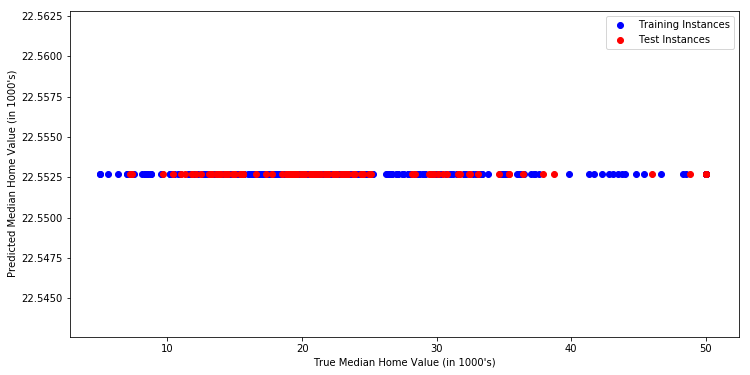

In [5]:
import time

#compute RMSE of the training set
mean_y = np.mean(bdata_train['MEDV'])
mean_y_train = [mean_y] * len(bdata_train['MEDV'])
rmse_train = compute_rmse(mean_y_train, bdata_train['MEDV'])
print('The RMSE of the training set is :', rmse_train)

#compute RMSE of the test set and measure running time
t_start = time.clock()
mean_y = np.mean(bdata_train['MEDV'])
mean_y_test = [mean_y] * len(bdata_test['MEDV'])
rmse_test = compute_rmse(mean_y_test, bdata_test['MEDV'])
t_end = time.clock()
print('The RMSE of the test set is :', rmse_test)
print('Time required to compute predicted values for test data: ', t_end - t_start,'s')

fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(bdata_train['MEDV'], mean_y_train, color = 'blue')
ax.scatter(bdata_test['MEDV'], mean_y_test, color = 'red')
ax.set_xlabel('True Median Home Value (in 1000\'s)')
ax.set_ylabel('Predicted Median Home Value (in 1000\'s)')
ax.legend(['Training Instances', 'Test Instances'])


**Section 1.3**

**Answers :**

**Q1 :** The RMSE of the training data set is about 9.21.

**Q2 :** The RMSE of the test data set is 9.11.

**Q3 :** The RMSE for both the training and data set are very similar. This is expected because we are merely using the _mean_ of the median housing values to predict for all instances. Subsequently, the model "trained" will not overfit the training data set, and we expect to see similar performances in both training and test data set predictions. _(While they have similar RMSE, both performed poorly.)_

**Q5 :** It takes 0.0010472874150622147 seconds to compute the predicted values for the test data.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).
[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [6]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((3,4),(6,8),2))
5

"""
def distance(x1, x2, L):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    dist = np.sum((np.abs(x1-x2))**L, axis = 1)**(1/L)
    return dist

**_Note that the function distance() has been modified to work on arrays (using axis = 1) so that the distances between pairs of points can be calculated efficiently._**

### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Make sure to do the following
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

In [7]:
"""
Function
--------
nneighbor

Given a training set containing features and the target, predict target value for each instance in test set using basic nearest neighbors.

Parameters
----------
df_train_X, df_train_y : pandas dataframe
    Dataframe of values corresponding to predictive features and corresponding predictions.

df_test_X, df_test_y : pandas dataframe
    Dataframe df_test_X is used to predict df_test_y. df_test_y will be used calculate the RMSE of predicted y values.
    
trainSet: int (0 or 1)
    Report RMSE of train set or test set. '0' selects test set while '1' selects training set.
    
L: int
    Value of L to use in computing distances.

Returns
-------
rmse : float
    The RMSE between predicted target values and actual target values. 

predicted_y : list
    An array containing predicted target values. 

"""
def nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, trainSet, L):
    start_time = time.time()
    df_X = df_test_X # default is test set
    df_Y = df_test_y
    if trainSet == 1:
        df_X = df_train_X
        df_Y = df_train_y
        
    predicted_y = []
            
    for i in range(len(df_X)):
        dist = list(distance(df_X.iloc[i,:], df_train_X, L))
        
        if trainSet == 1: # choose second smallest distance if we are calculating RMSE of training set
            df_train_ydrop = df_train_y.drop(df_train_y.index[np.argmin(dist)])
            dist.pop(np.argmin(dist))
            predict = df_train_ydrop.iloc[np.argmin(dist),:][0]
            predicted_y.append([predict])
        
        else:
            predict = df_train_y.iloc[np.argmin(dist),:][0]
            predicted_y.append([predict])

    rmse = compute_rmse(predicted_y, df_Y)
    print("Time taken: {:.5f} seconds".format(time.time() - start_time))
    return (rmse, predicted_y)

In [8]:
import time 
features = ['CRIM', 'RM']
L = 2

df_train_X = bdata_train.loc[:,features]
df_test_X = bdata_test.loc[:,features]
df_train_y = pd.DataFrame(bdata_train.loc[:,'MEDV'])
df_test_y = pd.DataFrame(bdata_test.loc[:,'MEDV'])

test_rmse, predicted_test = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 0, L)
training_rmse, predicted_train = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 1, L)
print('The test RMSE is :', test_rmse)
print('The training RMSE (second lowest) is:', training_rmse)

Time taken: 0.11396 seconds
Time taken: 1.12604 seconds
The test RMSE is : 7.706172723162627
The training RMSE (second lowest) is: 6.588825674001114


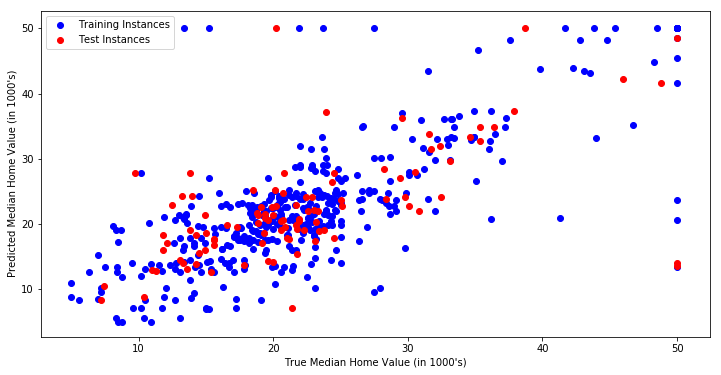

In [9]:
fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(bdata_train['MEDV'], predicted_train, color = 'blue')
ax.scatter(bdata_test['MEDV'], predicted_test, color = 'red')
ax.set_xlabel('True Median Home Value (in 1000\'s)')
ax.set_ylabel('Predicted Median Home Value (in 1000\'s)')
ax.legend(['Training Instances', 'Test Instances'])

**Section 2.2**

**Answers :**

**Q2 :** The test RMSE obtained is about 7.71.

**Q3 :** The training RMSE obtained is 0.0. The second lowest RMSE obtained is 6.59.

**Q5 :** The total time taken to predict the values in the test data set is 0.13093 seconds.

**Q6 :** The test RMSE of approximately 7.71 obtained from the nearest neighbor algorithm is significantly better than the baseline test RMSE of approximately 9.11. However, the nearest neighbor algorithm took about 0.131 seconds, while the baseline predictor took about 0.00105 seconds. Hence, while the nearest neighbor algorithm is better in terms of prediction accuracy, it is also slower than the baseline predictor. 

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

*NOTE 2*: In this case, there might not be a major impact on RMSE; don't get confused if you find that to be the case.

In [10]:
"""
Function
--------
normalize

Given an array, normalize each column using its mean and standard deviation and returns the array.

Parameters
----------
raw_data : array
    Array of data to be normalized. 

Returns
-------
normalized_data : array
    Array of normalized data.
"""
def normalize(raw_data):
    normalized_data = (raw_data - np.mean(raw_data))/np.std(raw_data)
    return normalized_data

In [11]:
df_train_X = pd.DataFrame(normalize(df_train_X))
df_test_X = pd.DataFrame(normalize(df_test_X))

test_rmse, predicted_test = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 0, 2)
training_rmse, predicted_train = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 1, 2)
print('The test RMSE is :', test_rmse)
print('The training RMSE (second lowest) is:', training_rmse)

Time taken: 0.09070 seconds
Time taken: 0.71557 seconds
The test RMSE is : 7.861322545021464
The training RMSE (second lowest) is: 6.450418284080805


**Section 2.3** 

**Answers :**

After normalizing the dataset, we obtain a test RMSE of 7.86, which is similar to the value of 7.71 obtained when we used the non-normalized dataset. Similarly, we obtain a training RMSE (second lowest) of 6.45, which is very close to the value of 6.59 obtained using the non-normalized dataset. Indeed, there is no major impact on RMSE in this case.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features

**Here, we investigate using a new set of feature pair: ['LSTAT','TAX'] for values of L = [1,2,3,4,5,6,7,8,9,10,11]**

In [12]:
features = ['LSTAT','TAX']
L = [i for i in range(1,12)]

test_vec = []
train_vec = []

df_train_X = pd.DataFrame(normalize(bdata_train.loc[:,features]))
df_test_X = pd.DataFrame(normalize(bdata_test.loc[:,features]))
df_train_y = pd.DataFrame(bdata_train.loc[:,'MEDV'])
df_test_y = pd.DataFrame(bdata_test.loc[:,'MEDV'])

for j in range(len(L)):
    
    print('Current Value of L: ', L[j])
    test_rmse, predicted_test = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 0, L[j])
    training_rmse, predicted_train = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 1, L[j])
    test_vec.append(test_rmse)
    train_vec.append(training_rmse)
    print('\n')

print('\nTest RMSE for L = [1:11] : ', test_vec)
print('\nTraining RMSE (second lowest) for L = [1:11] : ', train_vec)

Current Value of L:  1
Time taken: 0.06327 seconds
Time taken: 0.62072 seconds


Current Value of L:  2
Time taken: 0.06400 seconds
Time taken: 1.25410 seconds


Current Value of L:  3
Time taken: 0.17250 seconds
Time taken: 1.40997 seconds


Current Value of L:  4
Time taken: 0.18292 seconds
Time taken: 1.25900 seconds


Current Value of L:  5
Time taken: 0.12163 seconds
Time taken: 1.31545 seconds


Current Value of L:  6
Time taken: 0.17135 seconds
Time taken: 1.22284 seconds


Current Value of L:  7
Time taken: 0.12150 seconds
Time taken: 1.27678 seconds


Current Value of L:  8
Time taken: 0.12191 seconds
Time taken: 1.28294 seconds


Current Value of L:  9
Time taken: 0.15228 seconds
Time taken: 0.93539 seconds


Current Value of L:  10
Time taken: 0.09847 seconds
Time taken: 0.70769 seconds


Current Value of L:  11
Time taken: 0.07254 seconds
Time taken: 0.60458 seconds



Test RMSE for L = [1:11] :  [7.0726135724425125, 7.155314766784526, 7.084642324263455, 7.087271108452525, 

**Here, we investigate using a new set of feature pair: ['LSTAT','CRIM','RM','NOX','LSTAT'] for values of L = [1,2,3,4,5]**

In [13]:
features = ['LSTAT','CRIM','RM','NOX','CHAS', 'DIS']
L = [i for i in range(1,6)]

test_vec = []
train_vec = []

df_train_X = pd.DataFrame(normalize(bdata_train.loc[:,features]))
df_test_X = pd.DataFrame(normalize(bdata_test.loc[:,features]))
df_train_y = pd.DataFrame(bdata_train.loc[:,'MEDV'])
df_test_y = pd.DataFrame(bdata_test.loc[:,'MEDV'])

for j in range(len(L)):
    
    print('Current Value of L: ', L[j])
    test_rmse, predicted_test = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 0, L[j])
    training_rmse, predicted_train = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 1, L[j])
    test_vec.append(test_rmse)
    train_vec.append(training_rmse)
    print('\n')

print('\nTest RMSE for L = [1:5] : ', test_vec)
print('\nTraining RMSE (second lowest) for L = [1:5] : ', train_vec)

Current Value of L:  1
Time taken: 0.06101 seconds
Time taken: 0.54289 seconds


Current Value of L:  2
Time taken: 0.05383 seconds
Time taken: 0.60889 seconds


Current Value of L:  3
Time taken: 0.14207 seconds
Time taken: 1.27063 seconds


Current Value of L:  4
Time taken: 0.20148 seconds
Time taken: 1.28433 seconds


Current Value of L:  5
Time taken: 0.15412 seconds
Time taken: 1.30450 seconds



Test RMSE for L = [1:5] :  [4.359843494222889, 5.373610171431288, 5.440966609625428, 5.532860835011833, 5.561130862566374]

Training RMSE (second lowest) for L = [1:5] :  [4.612576973518563, 4.77967799984248, 4.796525660917659, 4.814242483825395, 4.781668791922289]


**Here, we investigate using all available features for values of L = [1,2,3,4,5,6]**

In [14]:
features = list(bdata_train.columns)[:-1] #remove 'MEDV' column 
L = [i for i in range(1,6)]

test_vec = []
train_vec = []

df_train_X = pd.DataFrame(normalize(bdata_train.loc[:,features]))
df_test_X = pd.DataFrame(normalize(bdata_test.loc[:,features]))
df_train_y = pd.DataFrame(bdata_train.loc[:,'MEDV'])
df_test_y = pd.DataFrame(bdata_test.loc[:,'MEDV'])

for j in range(len(L)):
    
    print('Current Value of L: ', L[j])
    test_rmse, predicted_test = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 0, L[j])
    training_rmse, predicted_train = nneighbor(df_train_X, df_test_X, df_train_y, df_test_y, 1, L[j])
    test_vec.append(test_rmse)
    train_vec.append(training_rmse)
    print('\n')

print('\nTest RMSE for L = [1:5] : ', test_vec)
print('\nTraining RMSE (second lowest) for L = [1:5] : ', train_vec)

Current Value of L:  1
Time taken: 0.15373 seconds
Time taken: 1.18772 seconds


Current Value of L:  2
Time taken: 0.15502 seconds
Time taken: 1.06600 seconds


Current Value of L:  3
Time taken: 0.14560 seconds
Time taken: 0.89871 seconds


Current Value of L:  4
Time taken: 0.12116 seconds
Time taken: 0.99197 seconds


Current Value of L:  5
Time taken: 0.14359 seconds
Time taken: 1.32691 seconds



Test RMSE for L = [1:5] :  [5.02399146058972, 4.671608028144854, 4.658273264195819, 4.618971959298337, 5.535332145480009]

Training RMSE (second lowest) for L = [1:5] :  [4.816447686504202, 4.558500383083702, 4.409603605812663, 4.424677646702381, 4.483294072729811]


**Section 2.4** 

**Answers :**

Here, we pick ['LSTAT','TAX'] as our new set of 2 features for median house value prediction. Using this feature pair and L = [1:11], the lowest RMSE obtained is when L = 10, where we obtain a test RMSE of 6.55. Note that a wider range of L was used in this case so we can observe the test RMSE remaining at ~6.55 for L >= 10.

In addition, we assessed the performance of using feature set ['LSTAT','CRIM','RM','NOX','CHAS','DIS'] for L = [1:5], and was able to achieve a minimum test RMSE of 4.36 when L = 1. 

Out of curiosity, we consider all available predictive values for L = [1:5]. In this case, we obtain a test RMSE of 4.62 for when L = 4. 

From the prediction times, increasing the number of features considered increases the running time of the algorithm. However, changing the value of L has a negligible effect on execution time. 

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations. What do you observe?
[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [15]:
"""
Function
--------
k_fold :

Given a data array and k, return two lists of indices, one for training and one for test. 

Parameters
----------
X : DataFrame
    The dataset on which k-fold cross-validation is performed. 
    
k : int 
    THe number of folds for k-fold cross-validation.

Returns
-------
(k_train, k_test) : lists
    Two lists of indices, one for training and one for test. Each list contains k lists. 
"""
def k_fold(X, kfold):
    dataset = X.copy()
    fold_size = int(len(dataset.iloc[:,0])/kfold)
    index = dataset.index
    index_c = index.copy()  
    
    k_train = []
    k_test = []

    for i in range(kfold):
        idx = np.random.choice(index_c,fold_size, replace = False)
        k_test.append(list(idx))
        k_train.append(list(set(index) - set(list(idx))))
        index_c = list(set(index_c) - set(list(idx)))

    return (k_train, k_test)

In [16]:
"""
Adjustable Parameters
"""
kfold = 10
features = ['CRIM', 'RM']
L = 2
"""
main
"""
import random
import time
np.random.seed(seed=13579)
X = pd.DataFrame(bdata.data, columns = bdata.feature_names)
y = pd.DataFrame(bdata.target, columns = ['MEDV'])

dataset = pd.DataFrame(normalize(X.loc[:,features]))
(k_train, k_test) = k_fold(dataset, kfold)
k_fold_rmse = []

start_time = time.time()
for i in range(kfold):
    
    k_test_rmse, predicted_test = nneighbor(dataset.iloc[k_train[i],:], dataset.iloc[k_test[i],:], y.iloc[k_train[i],:], y.iloc[k_test[i],:], 0, L)
    k_fold_rmse.append(k_test_rmse)
    
print('\nAverage k-fold RMSE:', np.mean(k_fold_rmse))
print('\nTotal Time Taken:', time.time() - start_time, 'seconds')

Time taken: 0.04271 seconds
Time taken: 0.05514 seconds
Time taken: 0.04797 seconds
Time taken: 0.03908 seconds
Time taken: 0.05672 seconds
Time taken: 0.04797 seconds
Time taken: 0.04897 seconds
Time taken: 0.04597 seconds
Time taken: 0.02269 seconds
Time taken: 0.03125 seconds

Average k-fold RMSE: 7.2170571376717545

Total Time Taken: 0.4770956039428711 seconds


**Section 2.5**

**Answers :**

We performed 10-fold cross validation using the basic nearest neighbor algorithm and obtained an average 10-fold RMSE of approximately 7.22. The total time taken for this computation is approximately 0.4 - 0.6 seconds (varies with each execution). 

We note that the 10-fold RMSE of 7.22 is similar to the 7.86 obtained when we merely split the normalized dataset into the training set (80%) and the test set (20%). Theoretically, it is arguable that the 10-fold RMSE is more representative of the predictive performance of the basic nearest neighbor algorithm. 

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

In [17]:
"""
Function
--------
knn (k-Nearest Neighbors)

Given a training set containing features and the target, predict target value for each instance in test set using k nearest neighbors.

Parameters
----------
df_train_X, df_train_y : pandas dataframe
    Dataframe of values corresponding to predictive features and corresponding predictions.

df_test_X, df_test_y : pandas dataframe
    Dataframe df_test_X is used to predict df_test_y. df_test_y will be used calculate the RMSE of predicted y values.
    
trainSet: int (0 or 1)
    Report RMSE of train set or test set. '0' selects test set while '1' selects training set.
    
L: int
    Value of L to use in computing distances.

Returns
-------
rmse : float
    The RMSE between predicted target values and actual target values. 
    
predicted_y : array
    An array of predicted target values.

"""

def knn(df_train_X, df_test_X, df_train_y, df_test_y, trainSet, L, K):
    #start_time = time.time()
    df_X = df_test_X # default is test set
    df_Y = df_test_y
    if trainSet == 1:
        df_X = df_train_X
        df_Y = df_train_y
        
    predicted_y = []
                
    for i in range(len(df_X)):
        dist = list(distance(df_X.iloc[i,:], df_train_X, L))
        k_smallest_y = []
        
        df_train_ydrop = df_train_y.copy()
        for i in range(K):
            predict = df_train_ydrop.iloc[np.argmin(dist),:][0]
            k_smallest_y.append([predict])
            df_train_ydrop.drop(df_train_ydrop.index[np.argmin(dist)], inplace = True)
            dist.pop(np.argmin(dist))

        k_mean_y = np.mean(k_smallest_y)
        predicted_y.append([k_mean_y])

    rmse = compute_rmse(predicted_y, df_Y)
    #print("Time taken: {:.5f} seconds".format(time.time() - start_time))
    return rmse, predicted_y


In [18]:

""" 
Adjustable Parameters: kfold, L, K, features
"""
K = 3
L = 2
kfold = 10
features = ['CRIM','RM']

"""
main
"""
import time 
import random
np.random.seed(seed=13579)
X = pd.DataFrame(bdata.data, columns = bdata.feature_names)
y = pd.DataFrame(bdata.target, columns = ['MEDV'])

dataset = pd.DataFrame(normalize(X.loc[:,features]))
(k_train, k_test) = k_fold(dataset, kfold)
k_fold_rmse = []

start_time = time.time()
for i in range(kfold):
    
    k_test_rmse, predicted_test = knn(dataset.iloc[k_train[i],:], dataset.iloc[k_test[i],:], y.iloc[k_train[i],:], y.iloc[k_test[i],:], 0, L, K)
    k_fold_rmse.append(k_test_rmse)
    
print('\nAverage k-fold RMSE:', np.mean(k_fold_rmse))
print('\nTotal Time Taken:', time.time() - start_time, 'seconds')


Average k-fold RMSE: 5.750512866078988

Total Time Taken: 1.8887627124786377 seconds


**Section 2.6**

**Answers :**

Using 10-fold cross-validation, L2 normalization, and K = 3, we obtain an average k-fold RMSE of about 5.75, which is significantly better than the average k-fold RMSE of about 7.22 using basic nearest neighbors. However, the execution time for this process is about 1.89 seconds. 

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [19]:
""" 
Adjustable Parameters
"""
K = [i for i in range(1,26)]
L = 2
kfold = 10
features = ['CRIM','ZN','RM','AGE','DIS','TAX']

"""
main
"""
import time 
import random
np.random.seed(seed=13579)

# initialize datasets
X = pd.DataFrame(bdata.data, columns = bdata.feature_names)
y = pd.DataFrame(bdata.target, columns = ['MEDV'])

dataset = pd.DataFrame(normalize(X.loc[:,features]))
(k_train, k_test) = k_fold(dataset, kfold)
K_rmse = []

### calculate mean rmse for each K value 
for i in range(len(K)):
    k_fold_rmse = []
    
### implement knn for every training-test pair
    for j in range(kfold):
    
        k_test_rmse, predicted_test = knn(dataset.iloc[k_train[j],:], dataset.iloc[k_test[j],:], y.iloc[k_train[j],:], y.iloc[k_test[j],:], 0, L, K[i])
        k_fold_rmse.append(k_test_rmse)
    
    K_rmse.append(np.mean(k_fold_rmse))

print('Average k-fold RMSE for K = [1:25]:\n', K_rmse)

Average k-fold RMSE for K = [1:25]:
 [5.877139840363544, 5.399352799509868, 4.8518105373312785, 4.804277584796243, 4.938444222460117, 5.012073348499986, 5.022332223177298, 5.038434048409415, 5.056571981867842, 5.0850621524459525, 5.104636270859297, 5.154671544440587, 5.187520565470206, 5.197388607404805, 5.212834853915199, 5.2089464065467315, 5.236432623064671, 5.224982845414205, 5.256459289397839, 5.293480516277858, 5.332547882455596, 5.350947669181674, 5.369345654434892, 5.407086741563575, 5.414619601612516]


Minimum RMSE occurs at K = 4  where RMSE =  4.804277584796243


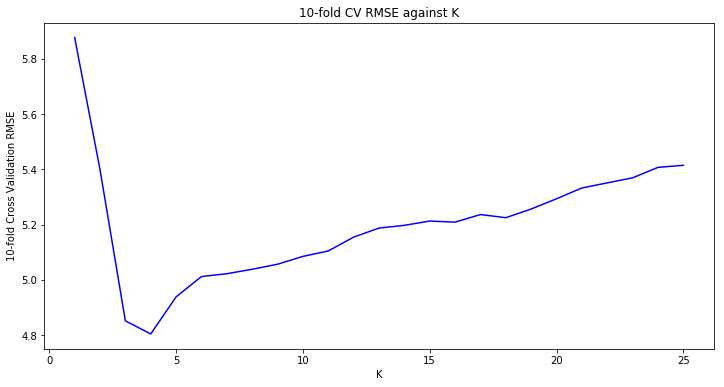

In [20]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(K, K_rmse, color = 'blue')
ax.set_xlabel('K')
ax.set_ylabel('10-fold Cross Validation RMSE')
ax.set_title('10-fold CV RMSE against K')
print('Minimum RMSE occurs at K =', K[np.argmin(K_rmse)],' where RMSE = ', K_rmse[np.argmin(K_rmse)])

**Section 2.7**

**Answers: ** 

As K increases from 1 to 25, it can be observed that the 10-fold cross-validation RMSE decreases before increasing steadily beyond K = 4. As such, the optimal value of K is 4, at which the RMSE is approximately 4.80. 

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to estimate relative importance of features
df1 = pd.DataFrame(bdata.data, columns = bdata.feature_names)
df1['MEDV'] = pd.DataFrame(bdata.target)
lin_model = smf.ols(formula = 'MEDV ~ CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT', data = df1).fit()
print(lin_model.summary())


D:\Users\Jonathan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 01 Oct 2018   Prob (F-statistic):          6.95e-135
Time:                        20:52:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4911      5.104      7.149      0.0

In [22]:
"""
Adjustable Parameters
"""
K = 4 # based on Section 2.7
kfold = 10
L = 2
features = ['NOX','RM','DIS','PTRATIO','LSTAT','RAD','CRIM','ZN','TAX','B','CHAS','INDUS','AGE'] #ordered based on p-values

"""
main
"""
import time
import random
np.random.seed(seed=13579)

#initialize datasets
X = pd.DataFrame(bdata.data, columns = bdata.feature_names)
y = pd.DataFrame(bdata.target)

#calculate k-fold RMSE for each additional feature
features_rmse = []
for j in range(1,len(features)+1):
    dataset = pd.DataFrame(normalize(X.loc[:,features[0:j]]))
    (k_train, k_test) = k_fold(dataset, kfold)
    k_fold_rmse = []

    ### implement knn for every training-test pair
    for i in range(kfold):

        k_test_rmse, predicted_test = knn(dataset.iloc[k_train[i],:], dataset.iloc[k_test[i],:], y.iloc[k_train[i],:], y.iloc[k_test[i],:], 0, L, K)
        k_fold_rmse.append(k_test_rmse)

    features_rmse.append(np.mean(k_fold_rmse))

print('Average 10-fold cross-validation RMSE (with each additional feature): \n\n', features_rmse)

Average 10-fold cross-validation RMSE (with each additional feature): 

 [6.589356001283311, 5.187837064918802, 5.32971679127593, 4.873082584055756, 3.422382337418898, 3.860821227400959, 3.5974809623075688, 3.747456478559144, 3.6678171734167924, 3.645859967047984, 4.123861169321837, 4.3740580849604065, 4.270517779848782]


Text(0.5,1,'Forward Selection: 10-fold CV RMSE Against Additional Feature')

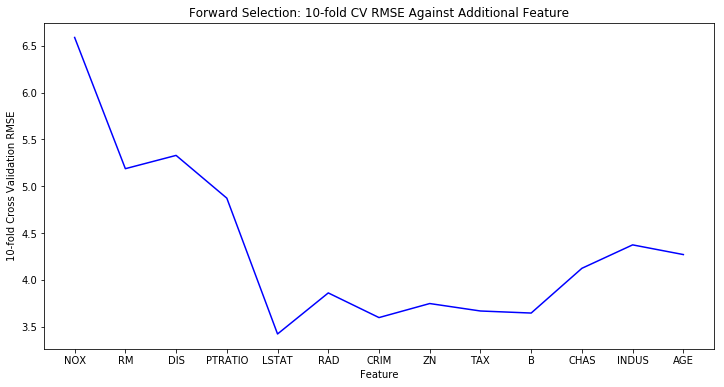

In [23]:
x = [i for i in range(len(features))]
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(features_rmse, color = 'blue')
plt.xticks(x,features)
ax.set_xlabel('Feature')
ax.set_ylabel('10-fold Cross Validation RMSE')
ax.set_title('Forward Selection: 10-fold CV RMSE Against Additional Feature')

**Section 2.7**

**Answers :**

Using results obtained from the OLS regression implementation, the predictive features were ranked according to their significance, starting with the most significant : ['NOX','RM','DIS','PTRATIO','LSTAT','RAD','CRIM','ZN','TAX','B','CHAS','INDUS','AGE']. We fix the value of K = 4, as determined from Section 2.6 so as to improve the efficiency of this implementation. Evidently, the 10-fold cross-validation RMSE decreases generally with each additional feature introduced to the model. 

For this particular sequence of feature addition, we find that the least RMSE can be obtained when the features used are ['NOX','RM','DIS',PTRATIO','LSTAT']. In this case, we obtain an RMSE of about 3.42. 

